In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../sqlalchemy-challenge/Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [6]:
# View all of the classes that automap found


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#explore columns for 'measurment' dataset
from sqlalchemy import inspect
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])



id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
#explore columns for 'station' dataset
from sqlalchemy import inspect
engine.execute('SELECT * FROM station LIMIT 5').fetchall()
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Find the most recent date in the data set.
rec_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
rec_date

('2017-08-23')

In [237]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
query_date 

datetime.date(2016, 8, 23)

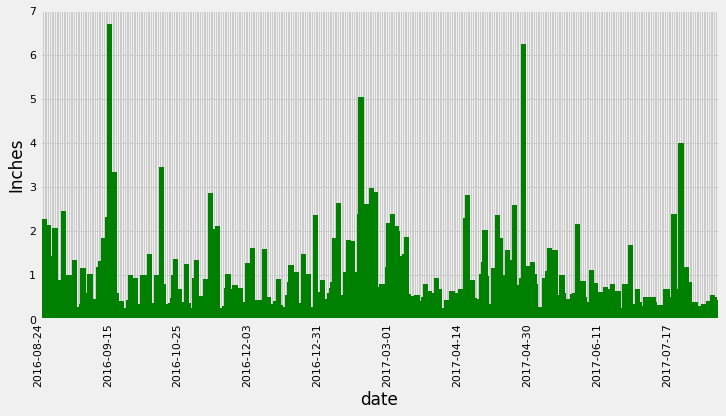

In [90]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Perform a query to retrieve the data and precipitation scores

result = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-23').\
        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(result)
precip_df.set_index("date", inplace = True)

#drop NaN and Zero values
#precip_nonzero_df = precip_df.loc[precip_df["prcp"] > 0.2,:]
#precip_clean_df = precip_nonzero_df.dropna(how = 'any')
#precip_clean_df

# Sort the dataframe by date
precip_sort_df = precip_df.sort_index(ascending=True)
precip_nonan_df = precip_sort_df.dropna(how = 'any')

precip_nonan_df

# Use Pandas Plotting with Matplotlib to plot the data
#drop NaN and filter values > 0.2 to have a cleaner graph 
precip_nonzero_df = precip_nonan_df.loc[precip_nonan_df["prcp"] > 0.2,:]
precip_clean_df = precip_nonzero_df.dropna(how = 'any')
precip_clean_df

ax = precip_clean_df.plot(kind = "bar", figsize = (10,6), color = "g", legend=False, width  = 3)

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(precip_clean_df.index)

# Every 247th ticklable shows the month and day
ticklabels[::40] = precip_clean_df.index[::40]

ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))

plt.gcf().autofmt_xdate()
plt.xticks(fontsize=11, rotation = 90)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.ylabel("Inches")

plt.show()


In [88]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_nonan_df.agg({"prcp": ['mean','median','min', 'max', 'var','std', ]})

,prcp
mean,0.176462
median,0.020000
min,0.000000
max,6.700000
var,0.211865
std,0.460288


# Exploratory Station Analysis

In [107]:
# Design a query to calculate the total number of stations in the dataset
stations_count=session.query(func.count(Station.station)).all()
#print(f' number of station is {stations_count}')
stations_count



[(9)]

stations_count = session.query(Station.name, func.count(Station.id)).group_by(Station.name).all()
stations_count

session.query(Invoices.BillingCountry, func.sum(Invoices.Total)).\
    group_by(Invoices.BillingCountry).\
    order_by(func.sum(Invoices.Total).desc()).all()

In [182]:
#Design a query to find the most active stations (i.e. which stations have the most rows?).
#List the stations and observation counts in descending order.
active_stn = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()

active_stn

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [216]:
#Which station id has the highest number of observations?
most_active = active_stn[0][0]
print(f'The station with the highest number of observations is {most_active}')

The station with the highest number of observations is USC00519281


In [226]:
#????????????????????
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [224]:
#????????????????????
sel = [Measurement.station, Station.name, Measurement.date, Measurement.tobs]
q = session.query(*sel).filter(Measurement.station == Station.station).all()

q_df = pd.DataFrame(q)
q_df.groupby("station").agg({"tobs": ['min','max','mean','count']})

tobs                       
              min   max       mean count
station                                 
USC00511918  53.0  87.0  71.615968  1979
USC00513117  59.0  85.0  72.689184  2709
USC00514830  58.0  85.0  74.873297  2202
USC00516128  58.0  84.0  70.915008  2612
USC00517948  58.0  87.0  74.684402  1372
USC00518838  58.0  83.0  72.724070   511
USC00519281  54.0  85.0  71.663781  2772
USC00519397  56.0  87.0  74.553231  2724
USC00519523  56.0  85.0  74.543649  2669

In [235]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_st_stat = session.query(Measurement.station, Station.name, func.min(Measurement.tobs),\
        func.max(Measurement.tobs), func.avg(Measurement.tobs),func.count(Measurement.tobs)).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.station == most_active).\
        group_by(Measurement.station).all()

print(f'the temperature statistics for the most active station "{active_st_stat[0][1]}" is: ')
print(f' - lowest temperature is {active_st_stat[0][2]}; ')
print(f' - highest temperature is {active_st_stat[0][3]};')
print(f' - average temperature is {active_st_stat[0][4]};')
print(f' - total number of observations is {active_st_stat[0][5]} ')


the temperature statistics for the most active station "WAIHEE 837.5, HI US" is: 
 - lowest temperature is 54.0; 
 - highest temperature is 85.0;
 - average temperature is 71.66378066378067;
 - total number of observations is 2772 


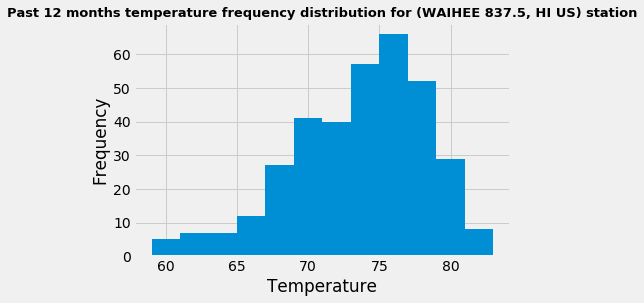

In [253]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_st_temp = session.query(Measurement.tobs).\
                filter(Measurement.date > '2016-08-23').\
                filter(Measurement.station == most_active).all()
active_st_temp

# Save the query results as a Pandas DataFrame and set the index to the date column
active_st_temp_df = pd.DataFrame(active_st_temp)
#active_st_temp_df.set_index("date", inplace = True)
active_st_temp_df.hist(bins = 12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Past 12 months temperature frequency distribution for " + "(" + active_st_stat[0][1] +")"+ " station", fontsize = 13, fontweight = 'bold')
plt.show()

# Close session

In [19]:
# Close Session
session.close()